# Threshold review using Provincial Totals

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pathlib import Path
from matplotlib.patches import Rectangle
import calendar

import os
import re
import rasterio
import geopandas as gpd
import rasterstats as rs
from fuzzywuzzy import process
from unidecode import unidecode
from scipy.stats.mstats import winsorize
from src.constants import *
from src.utils import *

# Display settings
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.1f}".format
sns.set(style="whitegrid")

In [3]:
district_df = pd.read_csv(
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "processed"
    / "moz"
    / "cholera"
    / "cholera_data_all_cleaned.csv"
)
# only keep those with week values
district_df = district_df[district_df["week"].notna()]

In [4]:
# maputo city values are divided into different admin units which are not admin 3
# we should start by summing all values for maputo city
summed = (
    district_df[district_df["province"] == "Maputo Cidade"]
    .groupby(["year", "week"], as_index=False)
    .sum(numeric_only=True)
)
summed["province"] = "Maputo Cidade"
summed["district"] = "Maputo Cidade"
summed
df_rest = district_df[district_df["province"] != "Maputo Cidade"]
district_df = pd.concat([df_rest, summed], ignore_index=True)
district_df

,province,district,year,week,cases
0,Cabo Delgado,Ancuabe,2017,1.0,104.0
1,Cabo Delgado,Ancuabe,2017,2.0,103.0
2,Cabo Delgado,Ancuabe,2017,3.0,81.0
3,Cabo Delgado,Ancuabe,2017,4.0,94.0
4,Cabo Delgado,Ancuabe,2017,5.0,84.0
...,...,...,...,...,...
60895,Maputo Cidade,Maputo Cidade,2025,19.0,928.0
60896,Maputo Cidade,Maputo Cidade,2025,20.0,"1,066.0"
60897,Maputo Cidade,Maputo Cidade,2025,21.0,"1,082.0"
60898,Maputo Cidade,Maputo Cidade,2025,22.0,"1,200.0"


In [5]:
# testing out winsorization
winsorized_values = district_df.groupby(["province", "district"])[
    "cases"
].transform(
    lambda x: winsorize(
        x, limits=[winsorising_lower_limit, winsorising_upper_limit]
    )
)
district_df["cases_winsorized"] = winsorized_values

In [6]:
# also adding the condition of max value in the past 24 months
province_df = (
    district_df.groupby(["province", "year", "week"])["cases"].sum()
).reset_index()
province_df

,province,year,week,cases
0,Cabo Delgado,2017,1.0,"1,446.0"
1,Cabo Delgado,2017,2.0,"1,272.0"
2,Cabo Delgado,2017,3.0,"1,244.0"
3,Cabo Delgado,2017,4.0,"1,435.0"
4,Cabo Delgado,2017,5.0,"1,309.0"
...,...,...,...,...
4552,Zambezia,2024,48.0,"1,532.0"
4553,Zambezia,2024,49.0,"1,544.0"
4554,Zambezia,2024,50.0,"1,505.0"
4555,Zambezia,2024,51.0,"1,227.0"


In [7]:
# smoothing the number of cases by province using a simple moving average over 3 weeks
province_df["cases"] = (
    province_df["cases"].rolling(window=3, min_periods=1).mean()
)

In [8]:
def flag_max_with_buffer(group):
    group["rolling_max"] = (
        group["cases"].shift(12).rolling(window=104, min_periods=25).max()
    )
    group["is_new_max"] = False
    mask = group["rolling_max"].notna() & (
        group["cases"] >= group["rolling_max"]
    )
    group.loc[mask, "is_new_max"] = True
    return group


province_events = (
    province_df.groupby("province", group_keys=True)
    .apply(flag_max_with_buffer, include_groups=False)
    .reset_index()
)
province_events["consecutive_weeks_3"] = (
    province_events.groupby("province")["is_new_max"]
    .transform(
        lambda x: x.rolling(window=3, min_periods=3).apply(
            lambda w: all(w), raw=False
        )
    )
    .fillna(False)
    .astype(bool)
)

province_events

,province,level_1,year,week,cases,rolling_max,is_new_max,consecutive_weeks_3
0,Cabo Delgado,0,2017,1.0,"1,446.0",NaN,False,False
1,Cabo Delgado,1,2017,2.0,"1,359.0",NaN,False,False
2,Cabo Delgado,2,2017,3.0,"1,320.7",NaN,False,False
3,Cabo Delgado,3,2017,4.0,"1,317.0",NaN,False,False
4,Cabo Delgado,4,2017,5.0,"1,329.3",NaN,False,False
...,...,...,...,...,...,...,...,...
4552,Zambezia,4552,2024,48.0,"1,573.0","2,377.3",False,False
4553,Zambezia,4553,2024,49.0,"1,571.3","2,377.3",False,False
4554,Zambezia,4554,2024,50.0,"1,527.0","2,377.3",False,False
4555,Zambezia,4555,2024,51.0,"1,425.3","2,377.3",False,False


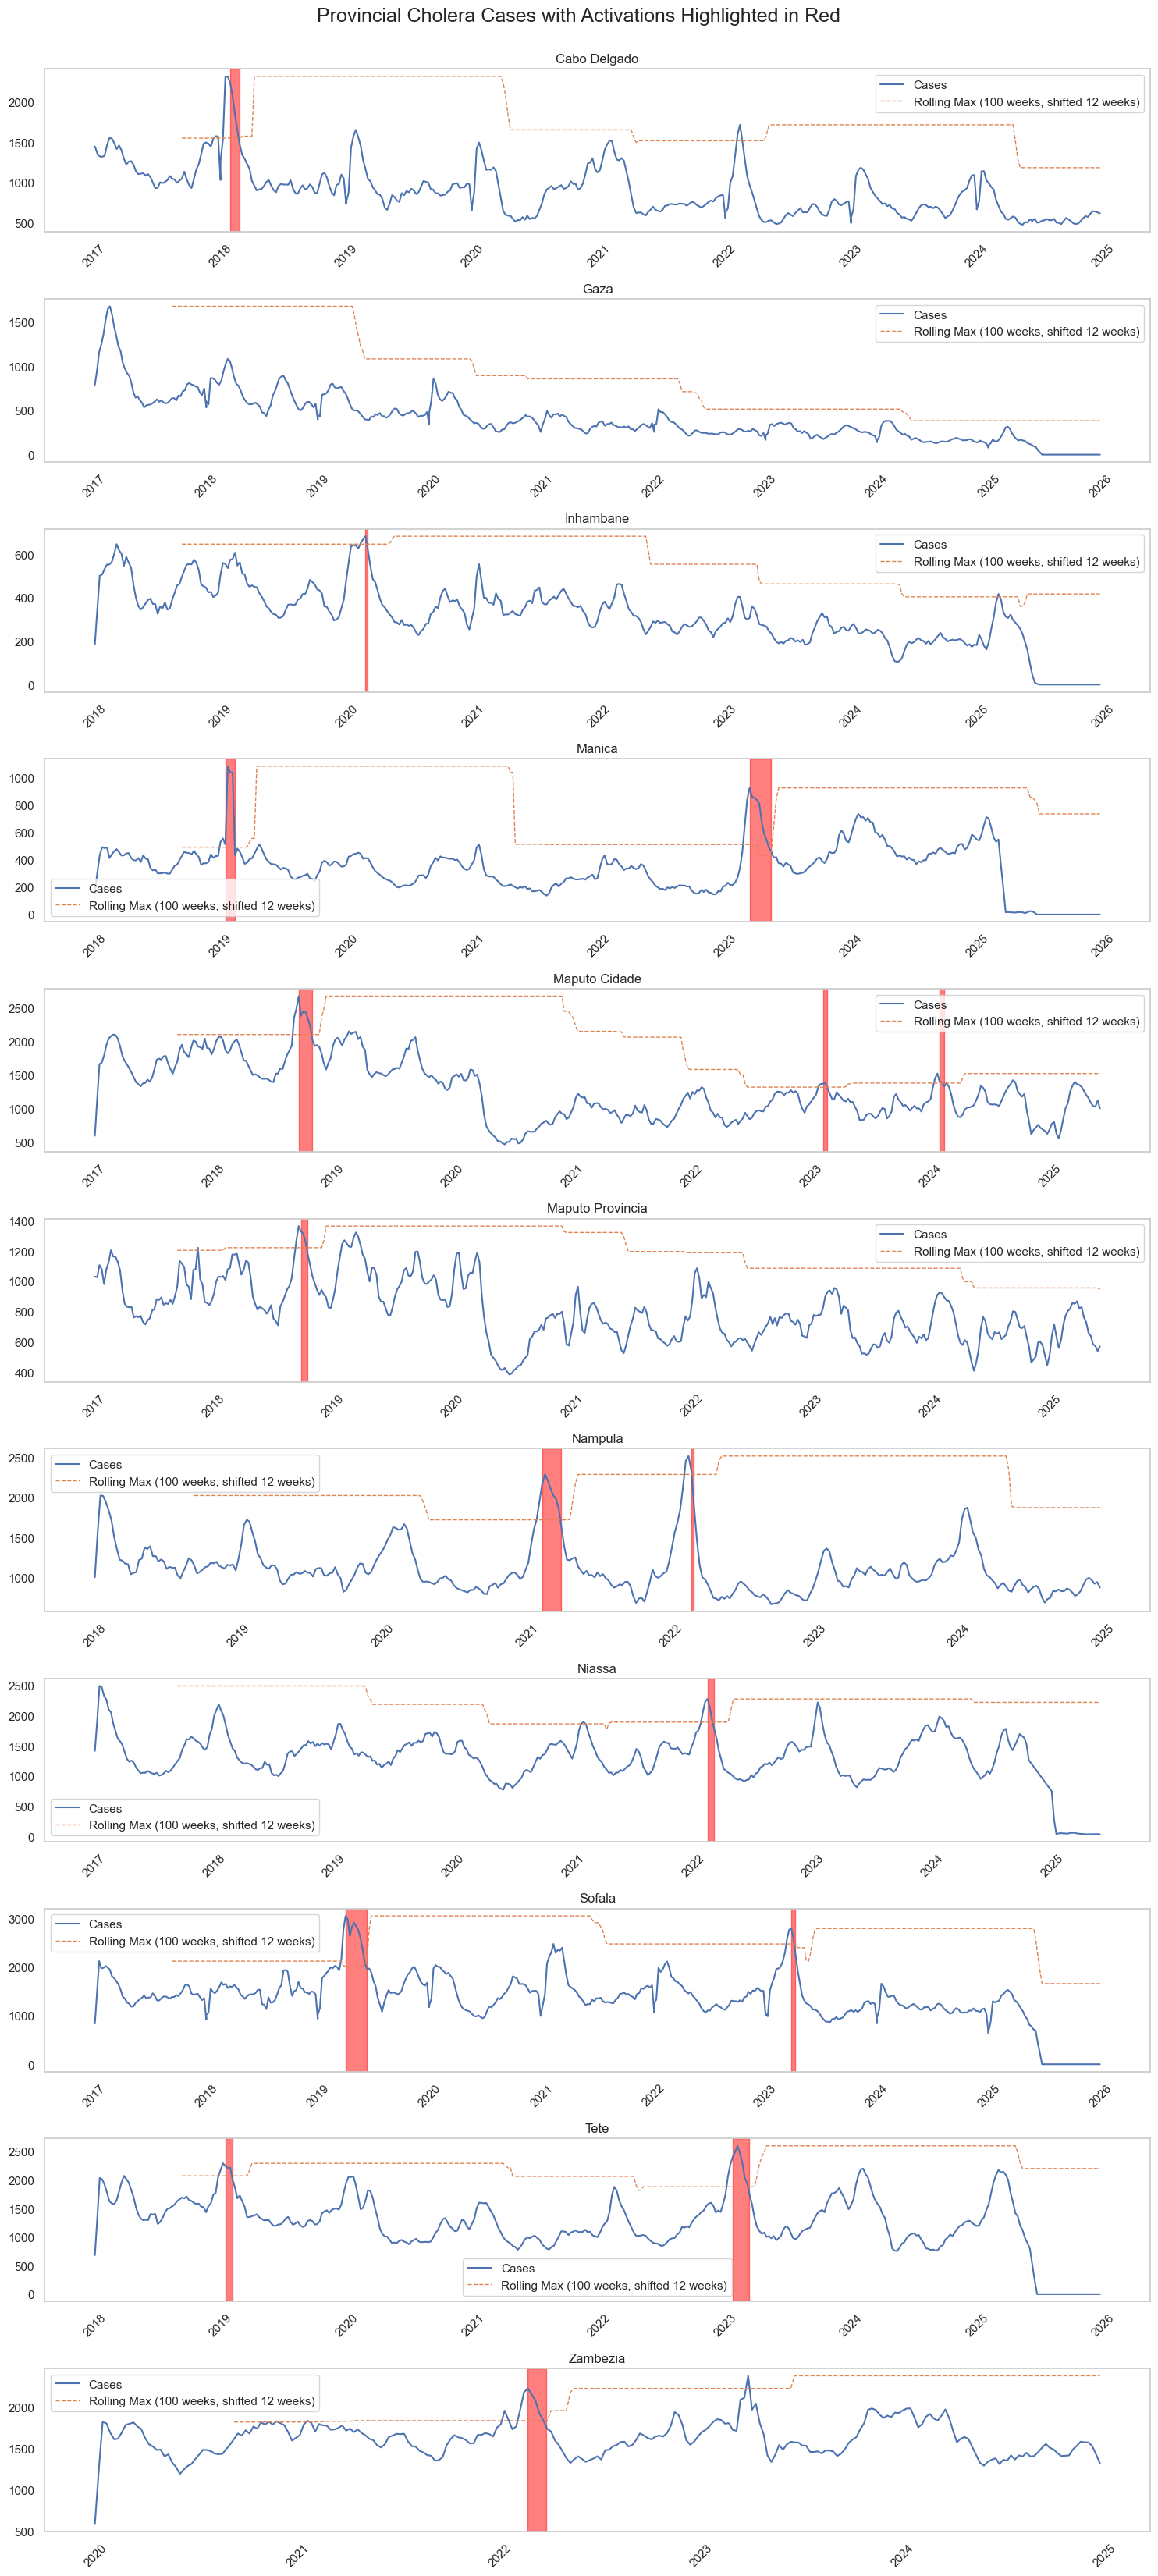

In [19]:
# quick plot
province_events["date"] = pd.to_datetime(
    province_events["year"].astype(str)
    + province_events["week"].astype(int).astype(str)
    + "-1",
    format="%G%V-%w",
)

provinces = province_events["province"].unique()
n_prov = len(provinces)

fig, axes = plt.subplots(n_prov, 1, figsize=(15, 3 * n_prov), sharex=False)

if n_prov == 1:
    axes = [axes]  # ensure iterable if only one province

for ax, prov in zip(axes, provinces):
    subset = province_events[province_events["province"] == prov]
    ax.plot(subset["date"], subset["cases"], label="Cases", linewidth=1.5)
    ax.plot(
        subset["date"],
        subset["rolling_max"],
        label="Rolling Max (100 weeks, shifted 12 weeks)",
        linestyle="--",
        linewidth=1,
    )
    ax.set_title(prov)
    ax.legend()
    ax.tick_params(axis="x", rotation=45)
    ax.grid(False)
    y_min, y_max = ax.get_ylim()
    height = y_max - y_min

    # mask for consecutive weeks == True
    mask = subset["consecutive_weeks_3"].astype(bool)
    starts = subset.loc[mask & ~mask.shift(fill_value=False), "date"]
    ends = subset.loc[mask & ~mask.shift(-1, fill_value=False), "date"]

    for start_date, end_date in zip(starts, ends):
        # extend end_date by 6 days so the last week is fully covered
        end_date = end_date + pd.Timedelta(days=6)

        # rectangle width as a timedelta
        width = end_date - start_date

        rect = Rectangle(
            (start_date, y_min),  # bottom-left corner
            width,  # width as Timedelta
            height,  # full plot height
            fill=True,
            color="red",
            alpha=0.5,
            linewidth=1,
        )
        ax.add_patch(rect)

plt.suptitle(
    "Provincial Cholera Cases with Activations Highlighted in Red",
    fontsize=18,
    y=1,
)
plt.tight_layout()
plt.show()

C:\Users\pauni\AppData\Local\Temp\ipykernel_13132\1274685453.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_with_cooldown, months=2)


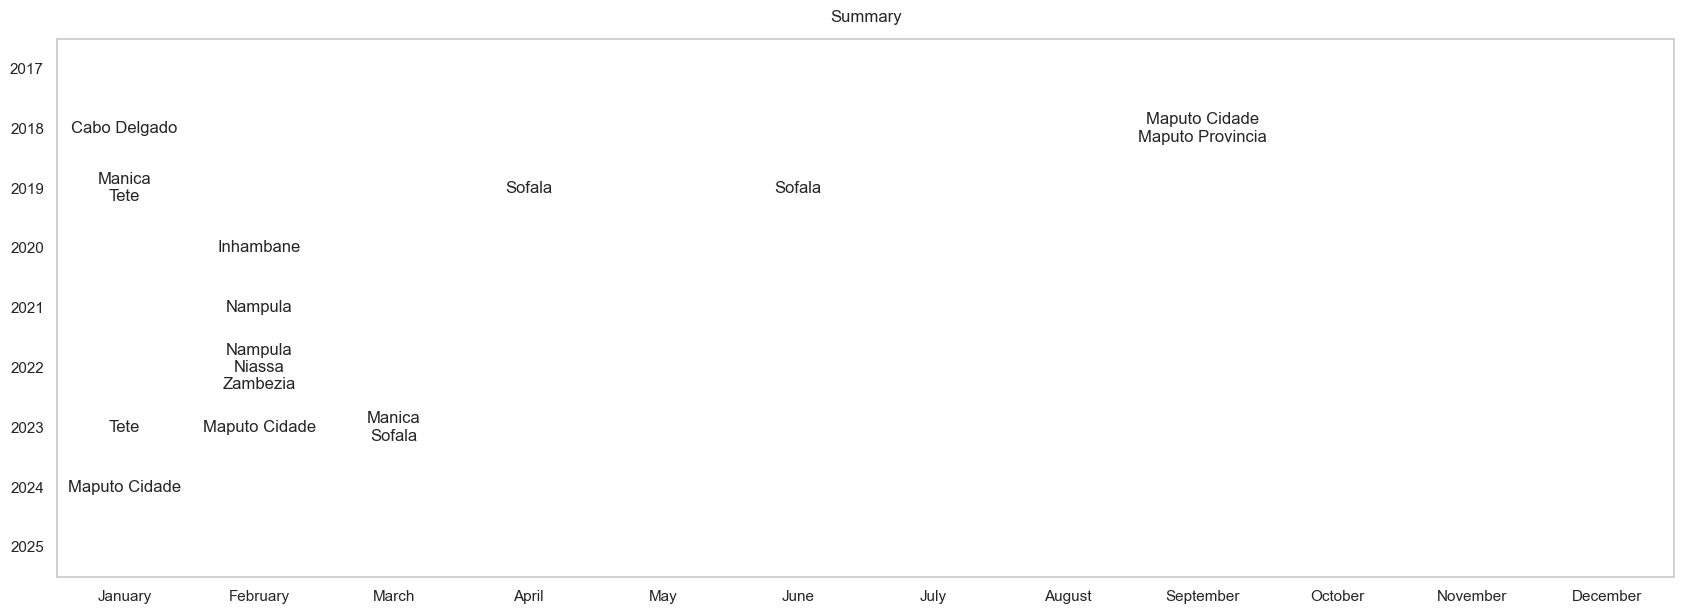

In [10]:
province_events = province_events.copy()
province_events["date"] = pd.to_datetime(
    province_events["year"].astype(str)
    + province_events["week"].astype(int).astype(str).str.zfill(2)
    + "-1",
    format="%G%V-%w",
)


def keep_with_cooldown(g, months=2):
    g = g.sort_values("date")
    keep = []
    next_ok = pd.Timestamp.min
    for d in g["date"]:
        if d >= next_ok:
            keep.append(True)
            next_ok = d + pd.DateOffset(months=months)
        else:
            keep.append(False)
    return g.loc[keep]


pe = (
    province_events.loc[province_events["consecutive_weeks_3"]]
    .groupby("province", group_keys=False)
    .apply(keep_with_cooldown, months=2)
    .reset_index(drop=True)
)

pe["year_num"] = pe["date"].dt.year
pe["month_name"] = pe["date"].dt.month_name()

pe["year_num"] = pe["date"].dt.year
pe["month_name"] = pe["date"].dt.month_name()

year_range = list(range(2017, 2026))

cells = (
    pe.assign(
        month_name=pd.Categorical(
            pe["month_name"], categories=month_order, ordered=True
        )
    )
    .groupby(["year_num", "month_name"], as_index=False, observed=False)[
        "province"
    ]
    .agg(lambda s: "\n".join(sorted(pd.unique(s.astype(str)))))
)

grid = (
    cells.pivot(index="year_num", columns="month_name", values="province")
    .reindex(index=year_range, columns=month_order)
    .fillna("")
)

years = year_range
fig_h = max(4, 0.7 * len(years))
fig, ax = plt.subplots(figsize=(17, fig_h))

ax.set_xlim(-0.5, 11.5)
ax.set_ylim(-0.5, len(years) - 0.5)
ax.set_xticks(range(12))
ax.set_xticklabels(month_order)
ax.set_yticks(range(len(years)))
ax.set_yticklabels(years)
ax.set_title("Summary", pad=12)
ax.grid(False)
ax.invert_yaxis()

for i, y in enumerate(years):
    for j, m in enumerate(month_order):
        txt = grid.loc[y, m]
        if txt:  # leave empty cells blank
            ax.text(j, i, txt, ha="center", va="center")

plt.tight_layout()
plt.show()